<a href="https://colab.research.google.com/github/minhdenthedev/Fashion-Auto-SEO/blob/main/classification_for_blip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

captions = pd.read_csv('/content/drive/MyDrive/data/cleaned_caption.csv', delimiter='|')
captions.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
captions['image_name'] = captions['Index']
captions.head()
captions.to_csv('cleaned_caption.csv', index=False)

### Download images:

In [ ]:
import os
import requests

save_path = '/content/drive/MyDrive/data'

for category in pd.unique(captions['category']):
  if not os.path.exists(os.path.join(save_path, category)):
    os.makedirs(os.path.join(save_path, category))

for idx, row in captions.iterrows():
  url = row['image_url']
  data = requests.get(url).content
  image_path = os.path.join(save_path, row['category'], f'{idx}.jpg')
  with open(image_path,'wb') as f:
    f.write(data)
  print(f'Downloaded {image_path}')
else:
  print(f'Downloaded {idx+1} images.')

Downloaded /content/drive/MyDrive/data/quan_short_nam/0.jpg
Downloaded /content/drive/MyDrive/data/quan_short_nam/1.jpg
Downloaded /content/drive/MyDrive/data/quan_short_nam/2.jpg
Downloaded /content/drive/MyDrive/data/quan_short_nam/3.jpg
Downloaded /content/drive/MyDrive/data/quan_short_nam/4.jpg
Downloaded /content/drive/MyDrive/data/quan_short_nam/5.jpg
Downloaded /content/drive/MyDrive/data/quan_short_nam/6.jpg
Downloaded /content/drive/MyDrive/data/quan_short_nam/7.jpg
Downloaded /content/drive/MyDrive/data/quan_short_nam/8.jpg
Downloaded /content/drive/MyDrive/data/quan_short_nam/9.jpg
Downloaded /content/drive/MyDrive/data/quan_short_nam/10.jpg
Downloaded /content/drive/MyDrive/data/quan_short_nam/11.jpg
Downloaded /content/drive/MyDrive/data/quan_short_nam/12.jpg
Downloaded /content/drive/MyDrive/data/quan_short_nam/13.jpg
Downloaded /content/drive/MyDrive/data/quan_short_nam/14.jpg
Downloaded /content/drive/MyDrive/data/quan_short_nam/15.jpg
Downloaded /content/drive/MyDrive/

KeyboardInterrupt: 

In [ ]:
!unzip -q /content/drive/MyDrive/data/fashion_images.zip

In [2]:
!unzip -q /content/drive/MyDrive/data/cropped_images.zip -d /content/

### Prepare dataset:

Images after preprocessing:
- Remove noisy images
- Cropping using YOLO

In [2]:
!unzip -q /content/drive/MyDrive/data/cropped_images.zip -d /content/

In [3]:
from torch.utils.data import Dataset, Subset
import os
from PIL import Image
import torchvision.transforms as transforms

class FashionDataset(Dataset):
  def __init__(self, image_dir):
    """
      image_dir=/content/drive/MyDrive/data
      image_dir
          |____ ao_hoodie_nam
          |____ ao_lien_quan
          ......
          |____ trung_nien_nu
    """
    self.image_dir = image_dir

    # read image and load label
    self.categories = sorted(os.listdir(image_dir))
    labels = {k:v for k, v in zip(self.categories, range(len(self.categories)))}
    self.num_classes = len(self.categories)
    self.images = []
    self.labels = []
    for category in self.categories:
      image_files = [f for f in os.listdir(os.path.join(image_dir, category)) if f.endswith(('.jpg', '.png'))]
      self.images.extend(image_files)
      self.labels.extend([labels[category]]*len(image_files))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_file = self.images[idx]
    label = self.labels[idx]
    category = self.categories[label]

    img = Image.open(os.path.join(self.image_dir, category, img_file)).convert('RGB')
    return img, label

class TransformedDataset(Dataset):
  def __init__(self, subset, transform=None):
    self.subset = subset
    if not transform:
      self.transform = transforms.ToTensor()
    else:
      self.transform = transform

  def __len__(self):
    return len(self.subset)

  def __getitem__(self, idx):
    img, label = self.subset[idx]
    return self.transform(img), label

### ResNet50:

In [4]:
import torch
import torch.nn as nn
import torchvision

class FashionModel(nn.Module):
  def __init__(self, num_classes=37):
    super().__init__()
    self.num_classes = num_classes
    self.backbone = torchvision.models.resnet50(torchvision.models.ResNet50_Weights.DEFAULT)

    last_num_features = self.backbone.fc.in_features
    self.backbone.fc = nn.Identity()
    self.fc = nn.Linear(in_features=last_num_features, out_features=num_classes)

  def forward(self, x):
    x = self.backbone(x)
    return self.fc(x)

### Train model:

In [5]:
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns

# create dataset
## data transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valtest_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_dir = '/content/cropped_images'
dataset = FashionDataset(image_dir=img_dir)
train_set, val_set, test_set = random_split(
    dataset,
    lengths=[0.6, 0.2, 0.2],
    generator=torch.Generator().manual_seed(42)
)
## apply transformation
train_set = TransformedDataset(train_set, transform=train_transform)
val_set = TransformedDataset(val_set, transform=valtest_transform)
test_set = TransformedDataset(test_set, transform=valtest_transform)

# create data loader
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
# create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FashionModel(num_classes=dataset.num_classes).to(device)

# loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# train loop
num_epochs = 100
best_acc = 0.0
patience = 10
patience_counter = 0
train_losses = [] # save train losses for visualization
val_losses = [] # save validation loss for visualization
for epoch in range(num_epochs):
  model.train()
  train_loss, correct, total = 0, 0, 0
  loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

  for images, labels in loop:
    images = images.to(device)
    labels = labels.to(device)

    # training phase
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

    # update visualization
    loop.set_postfix(loss=loss.item(), acc=correct / total)

  train_acc = 100 * correct / total
  train_losses.append(train_loss / len(train_loader))

  # evaluation phase
  model.eval()
  val_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum()

  val_losses.append(val_loss / len(val_loader))
  val_acc = correct / total
  print(f"Epoch {epoch+1}: Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

  # save checkpoint
  if val_acc > best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), "/content/drive/MyDrive/data/best.pth")
    patience_counter = 0
  else:
    patience_counter += 1
    if patience_counter >= patience:
      print(f'Early stopping at epoch {epoch+1}.')
      break
else:
  print(f'Finished {num_epochs} epochs.')
  torch.save(model.state_dict(), '/content/drive/MyDrive/data/last.pth')

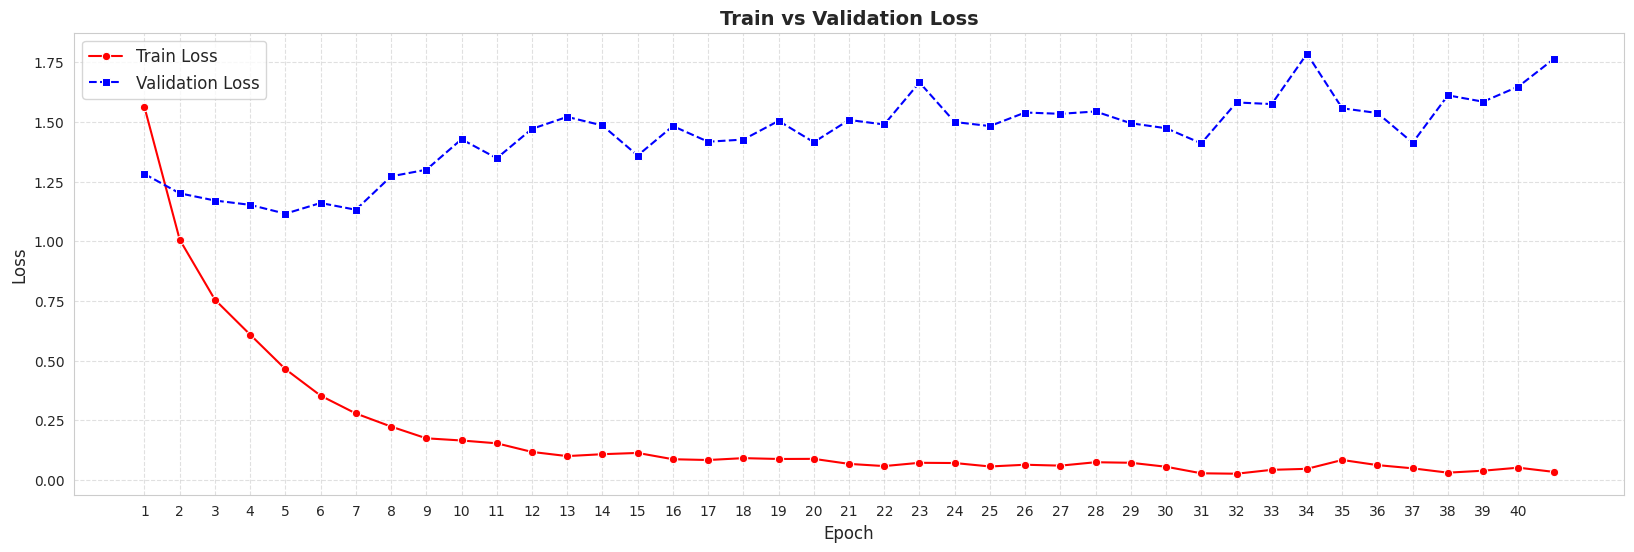

In [13]:
# train/val loss visualize
plt.figure(figsize=(20, 6))
sns.set_style("whitegrid")  # Thêm nền grid nhẹ

# Vẽ đường train loss
sns.lineplot(x=range(1, 42), y=train_losses, marker='o', linestyle='-', color='red', label="Train Loss")

# Vẽ đường val loss
sns.lineplot(x=range(1, 42), y=val_losses, marker='s', linestyle='--', color='blue', label="Validation Loss")

# Tùy chỉnh biểu đồ
plt.title("Train vs Validation Loss", fontsize=14, fontweight="bold")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(range(1, 41))
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig('/content/drive/MyDrive/data/train_val_losses.png')
# Hiển thị
plt.show()


In [14]:
train_labels = []
val_labels = []
test_labels = []
for images, label in train_loader:
  train_labels.extend(label.numpy())
for images, label in val_loader:
  val_labels.extend(label.numpy())
for images, label in test_loader:
  test_labels.extend(label.numpy())

Evaluate:

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FashionModel(num_classes=dataset.num_classes).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/data/best.pth'))
model.eval()
with torch.no_grad():
  correct, total = 0, 0
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
  print(f'\nTest accuracy: {correct / total}')

<ipython-input-8-2cd5311441e4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/data/best.pth'))



Test accuracy: 0.7329136729240417
